In [19]:
import pandas as pd
import numpy as np

from src.features import (
    create_time_features,
    create_lag_features,
    create_rolling_features
)

from src.model import train_model


In [20]:
df = pd.read_csv("../data/raw/train.csv")
df["date"] = pd.to_datetime(df["date"])
df.sort_values(["store", "item", "date"], inplace=True)


In [21]:
df = create_time_features(df)
df = create_lag_features(df)
df = create_rolling_features(df)

# Drop missing rows created by lags and rolling windows
df.dropna(inplace=True)


Lag and rolling features introduce missing values by design; these rows are removed after feature creation.


In [22]:
split_date = df["date"].max() - pd.Timedelta(days=90)

train_df = df[df["date"] <= split_date]
val_df = df[df["date"] > split_date]


Chronological split prevents data leakage.


In [23]:
FEATURES = [col for col in df.columns if col not in ["sales", "date"]]

X_train = train_df[FEATURES]
y_train = train_df["sales"]

X_val = val_df[FEATURES]
y_val = val_df["sales"]


In [27]:
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

# Train LightGBM using sklearn API (robust on all OS)
model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='mae'
)

val_pred = model.predict(X_val)
val_mae = mean_absolute_error(y_val, val_pred)
val_mae


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1510
[LightGBM] [Info] Number of data points in the train set: 854000, number of used features: 14
[LightGBM] [Info] Start training from score 52.497703


5.9194174142349425

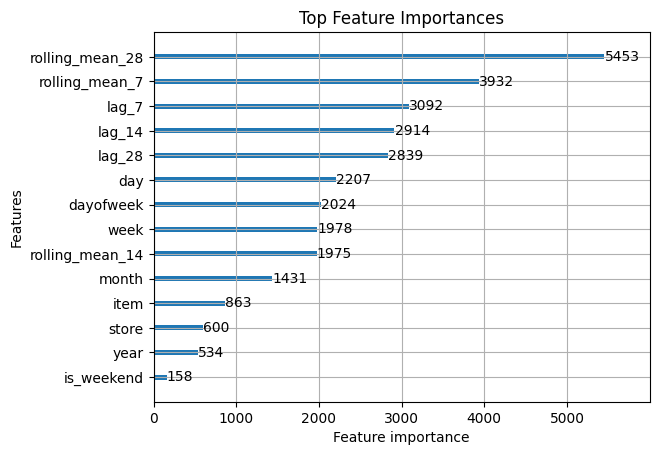

In [28]:
import matplotlib.pyplot as plt
import lightgbm as lgb

lgb.plot_importance(model, max_num_features=15)
plt.title("Top Feature Importances")
plt.show()


Lag features dominate → validates time-series structure  
Calendar features capture seasonality


In [29]:
import joblib
import os

# Ensure models folder exists
os.makedirs("../models", exist_ok=True)

joblib.dump(model, "../models/lgbm_demand_forecast.pkl")


['../models/lgbm_demand_forecast.pkl']